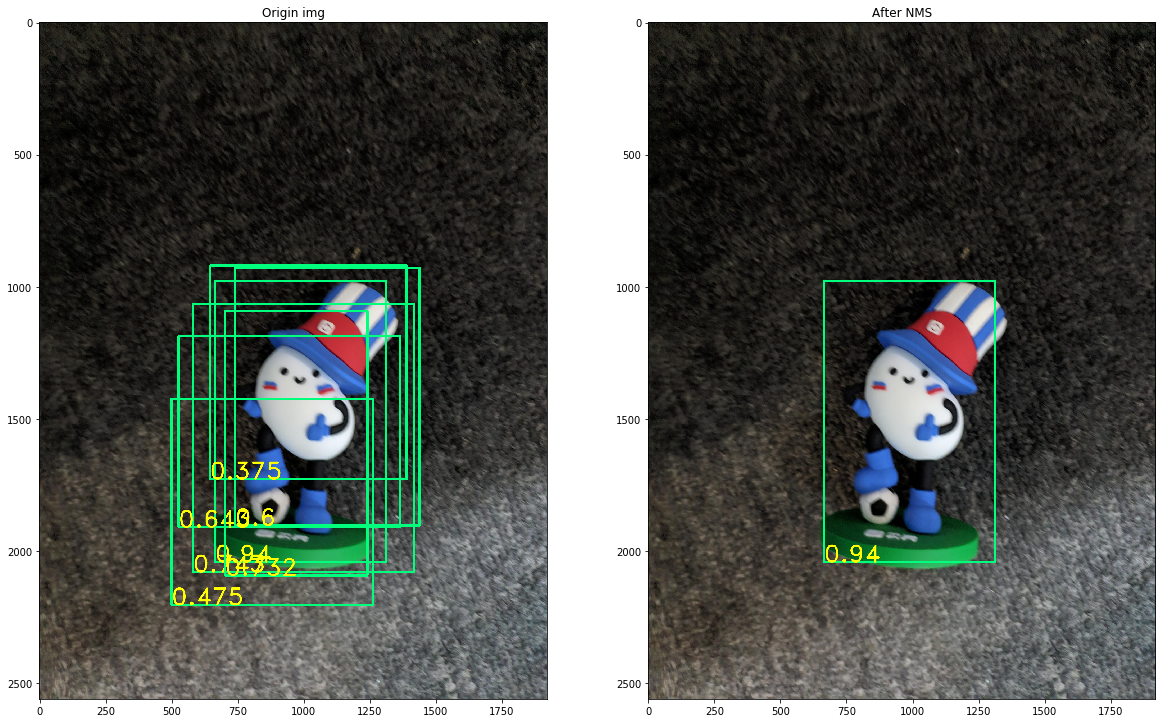

In [10]:
# -*- coding: utf-8 -*-
# @Time    : 2019-08-08 12:28
# @Author  : lzneu


import numpy as np
from shapely.geometry import Polygon  # 多边形
import json
from matplotlib import pyplot as plt
import cv2
from copy import deepcopy

%matplotlib inline

def show_img(img_path, dets1, dets2, tansed_name):
    # 图片展示
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ori = deepcopy(img)
    for det in dets1:
        score = det[4]
        det = list(map(int, det))
        img_ori = cv2.rectangle(img_ori, (det[0], det[1]), (det[2], det[3]), (0, 255, 125), 8)
        cv2.putText(img_ori, str(score), (det[0], det[3]), cv2.FONT_HERSHEY_DUPLEX,
                    3, (255, 255, 0), 4, cv2.LINE_AA)
    img_nms = deepcopy(img)
    for det in dets2:
        score = det[4]
        det = list(map(int, det))
        img_nms = cv2.rectangle(img_nms, (det[0], det[1]), (det[2], det[3]), (0, 255, 125), 8)
        cv2.putText(img_nms, str(score), (det[0], det[3]), cv2.FONT_HERSHEY_DUPLEX,
                    3, (255, 255, 0), 4, cv2.LINE_AA)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(img_ori)
    plt.title("Origin img")
    plt.subplot(1, 2, 2)
    plt.imshow(img_nms)
    plt.title(tansed_name)
    plt.show()


def nms(bounding_boxes, Nt):
    if len(bounding_boxes) == 0:
        return [], []
    bboxes = np.array(bounding_boxes)

    # 计算 n 个候选框的面积大小
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    scores = bboxes[:, 4]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 对置信度进行排序, 获取排序后的下标序号, argsort 默认从小到大排序
    order = np.argsort(scores)

    picked_boxes = []  # 返回值
    while order.size > 0:
        # 将当前置信度最大的框加入返回值列表中
        index = order[-1]
        picked_boxes.append(bounding_boxes[index])

        # 获取当前置信度最大的候选框与其他任意候选框的相交面积
        x11 = np.maximum(x1[index], x1[order[:-1]])
        y11 = np.maximum(y1[index], y1[order[:-1]])
        x22 = np.minimum(x2[index], x2[order[:-1]])
        y22 = np.minimum(y2[index], y2[order[:-1]])
        w = np.maximum(0.0, x22 - x11 + 1)
        h = np.maximum(0.0, y22 - y11 + 1)
        intersection = w * h

        # 利用相交的面积和两个框自身的面积计算框的交并比, 将交并比大于阈值的框删除
        ious = intersection / (areas[index] + areas[order[:-1]] - intersection)
        left = np.where(ious < Nt)
        order = order[left]
    return picked_boxes


def soft_nms(bboxes, Nt=0.3, sigma2=0.5, score_thresh=0.3, method=2):
    # 在 bboxes 之后添加对于的下标[0, 1, 2...], 最终 bboxes 的 shape 为 [n, 5], 前四个为坐标, 后一个为下标
    res_bboxes = deepcopy(bboxes)
    N = bboxes.shape[0]  # 总的 box 的数量
    indexes = np.array([np.arange(N)])  # 下标: 0, 1, 2, ..., n-1
    bboxes = np.concatenate((bboxes, indexes.T), axis=1)  # concatenate 之后, bboxes 的操作不会对外部变量产生影响

    # 计算每个 box 的面积
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    scores = bboxes[:, 4]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):
        # 找出 i 后面的最大 score 及其下标
        pos = i + 1
        if i != N - 1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0

        # 如果当前 i 的得分小于后面的最大 score, 则与之交换, 确保 i 上的 score 最大
        if scores[i] < maxscore:
            bboxes[[i, maxpos + i + 1]] = bboxes[[maxpos + i + 1, i]]
            scores[[i, maxpos + i + 1]] = scores[[maxpos + i + 1, i]]
            areas[[i, maxpos + i + 1]] = areas[[maxpos + i + 1, i]]

        # IoU calculate
        xx1 = np.maximum(bboxes[i, 0], bboxes[pos:, 0])
        yy1 = np.maximum(bboxes[i, 1], bboxes[pos:, 1])
        xx2 = np.minimum(bboxes[i, 2], bboxes[pos:, 2])
        yy2 = np.minimum(bboxes[i, 3], bboxes[pos:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        intersection = w * h
        iou = intersection / (areas[i] + areas[pos:] - intersection)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(iou.shape)
            weight[iou > Nt] = weight[iou > Nt] - iou[iou > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(iou * iou) / sigma2)
        else:  # original NMS
            weight = np.ones(iou.shape)
            weight[iou > Nt] = 0

        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    inds = bboxes[:, 5][scores > score_thresh]
    keep = inds.astype(int)

    return res_bboxes[keep]


img_path = './1.jpg'
json_path = img_path.replace('jpg', 'json')
dets = []
with open(json_path, encoding='utf-8') as j:
    data = json.load(j)
    for item in data['shapes']:
        det = item['points'][0] + item['points'][1] + [item['label']]
        dets.append(det)
dets = np.array(dets, dtype=np.float)

dets2 = nms(dets, Nt=0.3)
dets1 = dets
show_img(img_path, dets1, dets2, "After NMS")





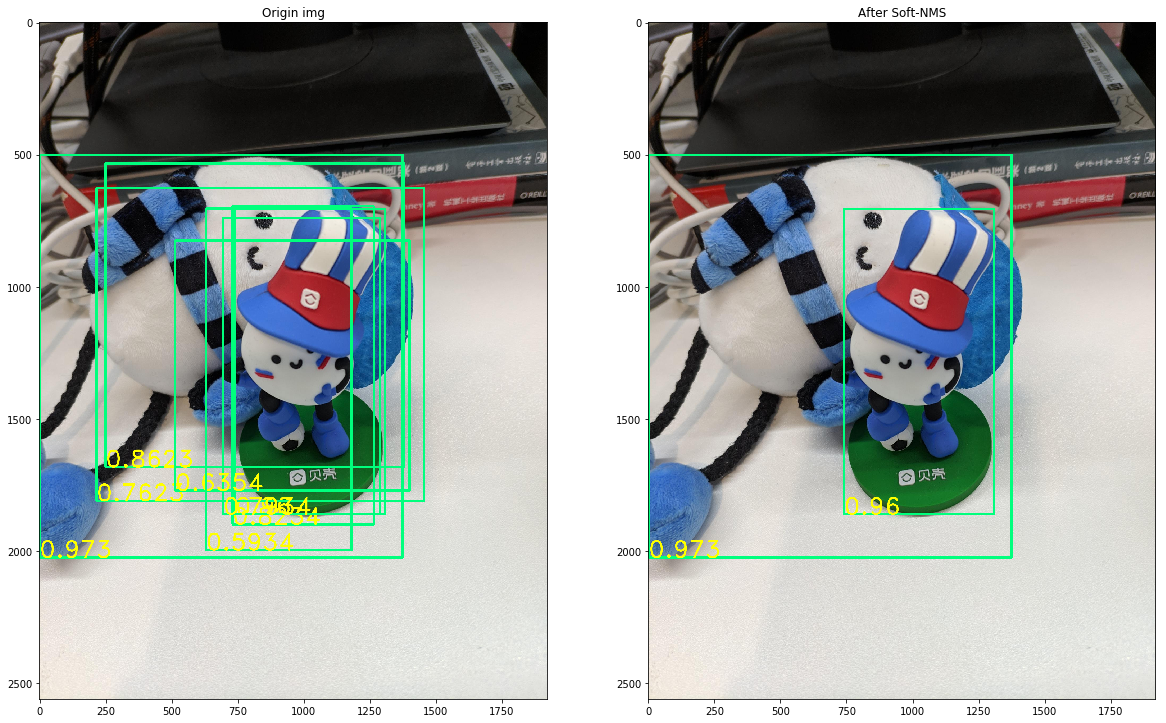

In [12]:

img_path = './2.jpg'
json_path = img_path.replace('jpg', 'json')
dets = []
with open(json_path, encoding='utf-8') as j:
    data = json.load(j)
    for item in data['shapes']:
        det = item['points'][0] + item['points'][1] + [item['label']]
        dets.append(det)
dets = np.array(dets, dtype=np.float)

dets2 = soft_nms(dets, Nt=0.3)
dets1 = dets
show_img(img_path, dets1, dets2, "After Soft-NMS")


In [16]:
# locality-aware-nms

import numpy as np
from shapely.geometry import Polygon


def intersection(g, p):
    # 取g,p中的几何体信息组成多边形
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))

    # 判断g,p是否为有效的多边形几何体
    if not g.is_valid or not p.is_valid:
        return 0

    # 取两个几何体的交集和并集
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter / union


def weighted_merge(g, p):
    # 取g,p两个几何体的加权（权重根据对应的检测得分计算得到）
    g[:8] = (g[8] * g[:8] + p[8] * p[:8]) / (g[8] + p[8])

    # 合并后的几何体的得分为两个几何体得分的总和
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    # 标准NMS
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])
        inds = np.where(ovr <= thres)[0]
        order = order[inds + 1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    locality aware nms of EAST
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []  # 合并后的几何体集合
    p = None  # 合并后的几何体
    for g in polys:
        if p is not None and intersection(g, p) > thres:  # 若两个几何体的相交面积大于指定的阈值，则进行合并
            p = weighted_merge(g, p)
        else:  # 反之，则保留当前的几何体
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)
    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)


0.94
0.96
0.8623
0.7623
0.8234
0.7934
0.5934
0.4934
0.6354
